Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [x] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

###Do train/validate/test split with the Tanzania Waterpumps data.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train and val
train, val = train_test_split(train,train_size=0.80, test_size=.20,
                              stratify=train['status_group'], random_state=7)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [3]:
# Check Pandas Profiling version
import pandas_profiling
pandas_profiling.__version__

'2.4.0'

In [0]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True)

profile.to_notebook_iframe()

In [0]:
# Save the profile report to an HTML file
profile.to_file(output_file='tanzania_profile_report_minimal.html')

In [7]:
# check out basic visualizations
import plotly.express as px
px.scatter(train, x='longitude',y='latitude',color='status_group',opacity=0.1)
# need to get rid of the crazy outlyres

In [8]:
train[['longitude','latitude']].describe()

,longitude,latitude
count,47520.000000,4.752000e+04
mean,34.071532,-5.699443e+00
std,6.567491,2.943513e+00
min,0.000000,-1.164944e+01
25%,33.087438,-8.532038e+00
50%,34.902873,-5.013405e+00
75%,37.177604,-3.325406e+00
max,40.345193,-2.000000e-08


In [9]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
26660,50225,0.0,2013-02-03,Rotary Club,1138,Rotary Club,36.901195,-3.391070,Kitefu Primary School,0,Pangani,Tanesco,Arusha,2,7,Meru,Maji ya Chai,350,True,GeoData Consultants Ltd,WUA,NaN,False,2009,gravity,gravity,gravity,wua,user-group,unknown,unknown,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
46901,67215,3000.0,2011-03-08,Danida,910,DANID,35.366883,-7.642936,none,0,Rufiji,Ndorobo B,Iringa,11,1,Iringa Rural,Mlowa,1,True,GeoData Consultants Ltd,VWC,Mlowa,True,1992,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1058,55164,1500.0,2013-02-12,Government Of Tanzania,682,District council,37.512633,-3.542461,Kwa Salim Idd,0,Pangani,Kitopeni,Kilimanjaro,3,2,Mwanga,Kileo,250,True,GeoData Consultants Ltd,WUA,Kifaru water Supply,True,2011,submersible,submersible,submersible,wua,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
9559,7310,0.0,2011-03-11,Government Of Tanzania,370,RWE,38.688599,-4.847517,Msikitini,0,Pangani,Dukani,Tanga,4,2,Korogwe,Kizara,150,True,GeoData Consultants Ltd,VWC,Bombomajimoto water,False,1975,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
35556,37576,0.0,2012-10-09,Rwssp,0,WEDECO,34.156026,-3.104921,Polewalandi,0,Lake Victoria,Makungu,Shinyanga,17,6,Meatu,Kisesa,0,True,GeoData Consultants Ltd,WUG,None,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [0]:
import numpy as np

def wrangle(X):

  # make a copy to avoid messing with the data
  X = X.copy()

  #replace the tiny value with 0
  X['latitude'] =X['latitude'].replace(-2e-08, 0)

  # replace 0s with nulls so that they can be imputed later
  cols_with_zeros = ['longitude','latitude','construction_year',
                     'gps_height','population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
  
  # quantity and quantity_group are duplicates, so drop one
  X = X.drop(columns='quantity_group')
  #recorded_by is all the same so I'm dropping it
  X = X.drop(columns='recorded_by')
  
  #convert date_recorded and to date data type
  X['date_recorded'] = pd.to_datetime(X['date_recorded'])
  
  # add a year column using the date_recorded
  X['year_inspection'] = X['date_recorded'].dt.year
  # add an age_at_inspection column
  X['age_at_inspection'] = X['year_inspection'] - X['construction_year']

  # convert funder and installer so that there is only 10 values plus an Other
  #top10a = X['funder'].value_counts()[:10].index 
  #X.loc[~train['funder'].isin(top10a), 'funder'] = 'OTHER'
  #top10b = X['installer'].value_counts()[:10].index 
  #X.loc[~train['installer'].isin(top10b), 'installer'] = 'OTHER'
  

  #return the wrangled dataframe
  return X

In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [13]:
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

###Select features. 

In [16]:
target = 'status_group'

train_features = train.drop(columns=[target,'id'])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()
features = numeric_features + categorical_features
print(len(features))
print(features)

31
['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'year_inspection', 'age_at_inspection', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [18]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

print(X_train.shape,X_val.shape)

(47520, 31) (11880, 31)


###Begin with baselines for classification.

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_val)
accuracy_score(y_val,y_pred)

0.5430976430976431

###Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(max_depth=15,random_state=7)
)

pipeline.fit(X_train,y_train);

###Get your validation accuracy score.

In [43]:
print('Training Accuracy:',pipeline.score(X_train,y_train))
print('Validation Accuracy:',pipeline.score(X_val,y_val))

Training Accuracy: 0.8319654882154882
Validation Accuracy: 0.7762626262626262


###Get and plot your feature importances.

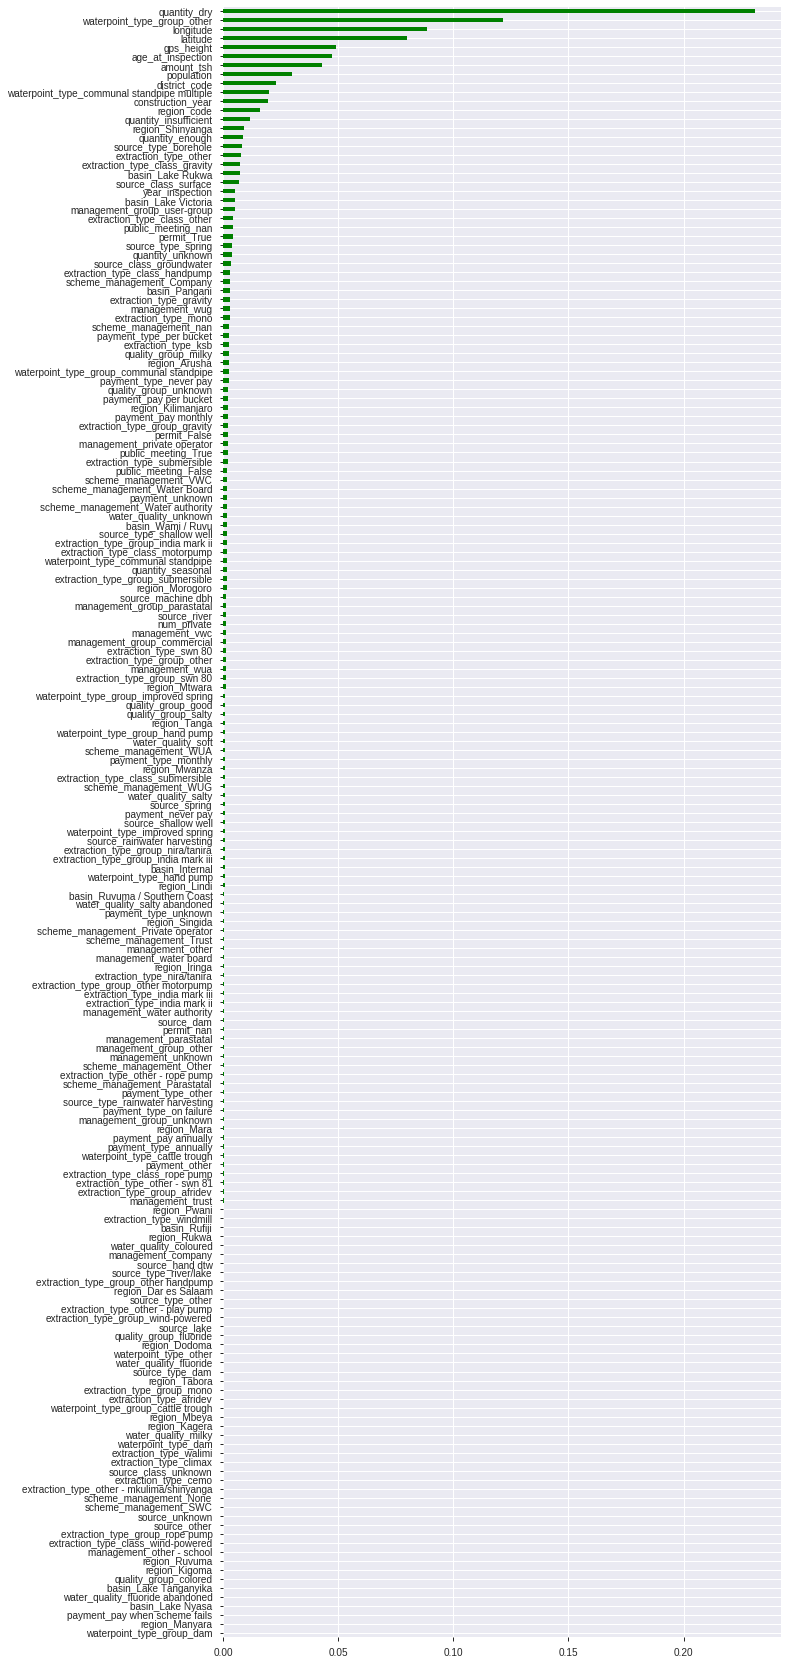

In [44]:
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.feature_importances_,encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='green');

### Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue Submit Predictions button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)

In [0]:
y_pred = pipeline.predict(X_test)
submission = sample_submission.copy()
submission['status_group']=y_pred
submission.to_csv('submission_1.csv',index=False)

###Commit your notebook to your fork of the GitHub repo.